# SGR Creep Compliance: Power-Law Creep in Biological Soft Matter

**Learning Objectives:**
- Fit SGR creep model to biological soft matter data
- Understand J(t) ~ t^(2-x) power-law creep behavior
- Handle limited data in Bayesian inference (wider posteriors)

**Prerequisites:** `basic/01_getting_started.ipynb`, `bayesian/01_bayesian_intro.ipynb`

**Runtime:**
- Fast mode (1 chain): ~2 min
- Full mode (4 chains): ~5 min

## 1. Setup

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import os
import json
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.sgr import SGRConventional, SGRGeneric

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

## 2. Theory: SGR Creep

The SGR creep compliance is given by:

$$J(t) = \frac{(1 + t/\tau_0)^{2-x}}{G_0 \cdot G_0(x)}$$

where $G_0(x) = \Gamma(2-x)\Gamma(x)/\Gamma(2)$ is the normalization factor.

**Growth exponent:** $(2-x)$

**Phase regimes:**
- $x < 1$: Very slow creep → elastic plateau (glass)
- $1 < x < 2$: Power-law creep (sublinear)
- $x = 2$: Linear creep (Newtonian fluid)
- $x > 2$: Super-diffusive creep

**Biological soft matter** (mucus) often exhibits soft glassy behavior with $1 < x < 2$, reflecting structural rearrangements under constant stress.

## 3. Load Data

In [4]:
data_path = os.path.join("..", "data", "creep", "biological", "creep_mucus_data.csv")
raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
t = raw[:, 0]
J_t = raw[:, 1]

print(f"Data points: {len(t)}")
print(f"Time range: {t.min():.1f} – {t.max():.1f} s")
print(f"J(t) range: {J_t.min():.4f} – {J_t.max():.4f} 1/Pa")

Data points: 20
Time range: 0.5 – 10.0 s
J(t) range: 0.9838 – 2.3724 1/Pa


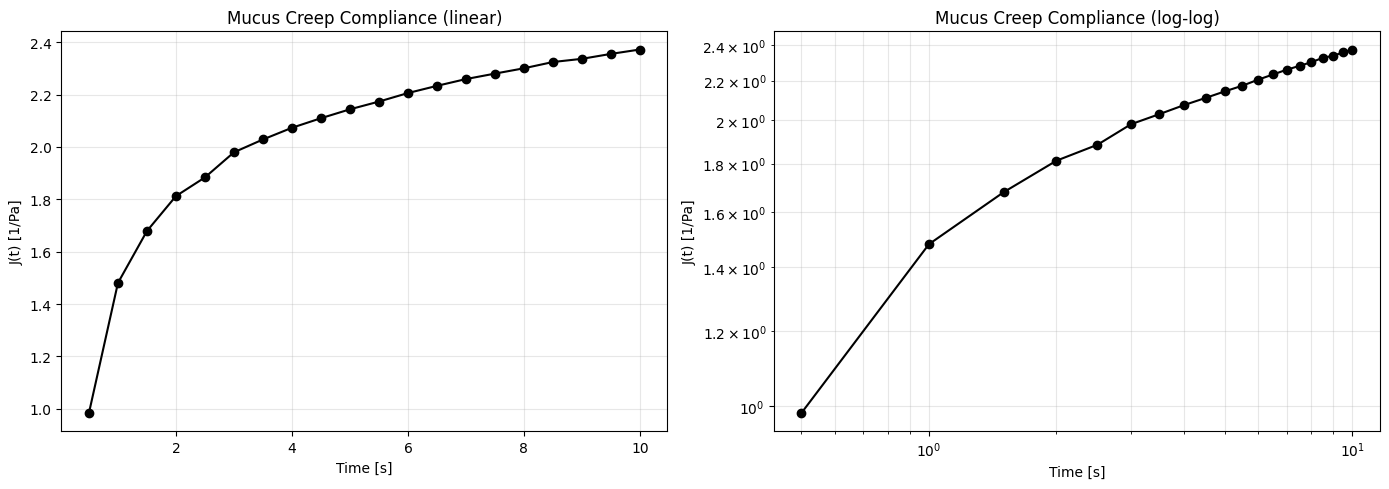

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(t, J_t, "ko-", markersize=6)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("J(t) [1/Pa]")
ax1.set_title("Mucus Creep Compliance (linear)")
ax1.grid(True, alpha=0.3)

ax2.loglog(t, J_t, "ko-", markersize=6)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("J(t) [1/Pa]")
ax2.set_title("Mucus Creep Compliance (log-log)")
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [6]:
model = SGRConventional()

t0_fit = time.time()
model.fit(t, J_t, test_mode="creep", method='scipy')
t_nlsq = time.time() - t0_fit

# Compute fit quality
J_pred_fit = model.predict(t)
metrics = compute_fit_quality(J_t, J_pred_fit)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} 1/Pa")
print("\nFitted parameters:")
for name in ["x", "G0", "tau0"]:
    val = model.parameters.get_value(name)
    print(f"  {name:5s} = {val:.4g}")
print(f"Phase regime: {model.get_phase_regime()}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.006925s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=52 | final_cost=0.0681 | elapsed=3.007s | final_gradient_norm=0.5733


NLSQ fit time: 4.62 s
R²: 0.766898
RMSE: 0.1634 1/Pa

Fitted parameters:
  x     = 1.68
  G0    = 996.8
  tau0  = 1.005e-09
Phase regime: power-law


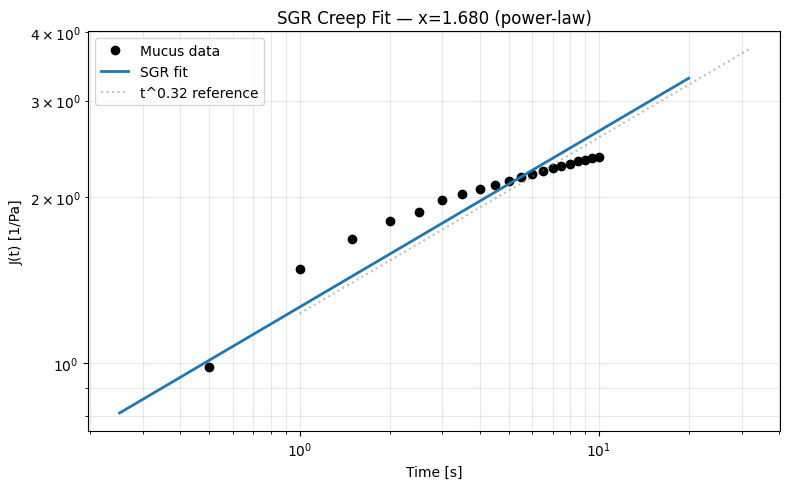

In [7]:
t_fine = np.logspace(np.log10(max(t.min(), 0.1)) - 0.3, np.log10(t.max()) + 0.3, 200)
J_pred = model.predict(t_fine)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(t, J_t, "ko", markersize=6, label="Mucus data")
ax.loglog(t_fine, J_pred, "-", lw=2, color="C0", label="SGR fit")

# Power-law reference
x_fit = model.parameters.get_value("x")
slope = 2 - x_fit
ref_t = np.logspace(0, 1.5, 50)
ref_J = J_t[0] * (ref_t / t[0]) ** slope
ax.loglog(ref_t, ref_J, ":", lw=1.5, color="gray", alpha=0.5, label=f"t^{slope:.2f} reference")

ax.set_xlabel("Time [s]")
ax.set_ylabel("J(t) [1/Pa]")
ax.set_title(f"SGR Creep Fit — x={x_fit:.3f} ({model.get_phase_regime()})")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 4.1 Creep Regime Exploration

Predict J(t) for different x values to show how the creep exponent changes.

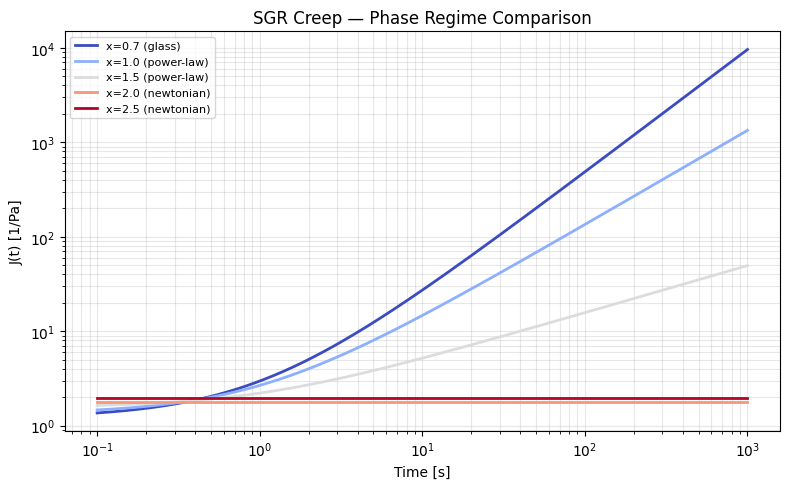

In [8]:
x_values = [0.7, 1.0, 1.5, 2.0, 2.5]
t_sweep = np.logspace(-1, 3, 200)

fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(x_values)))

for i, x_val in enumerate(x_values):
    m = SGRConventional()
    m.parameters.set_value("x", x_val)
    m.parameters.set_value("G0", 1.0)
    m.parameters.set_value("tau0", 1.0)
    m.fitted_ = True
    m._test_mode = "creep"

    J_sweep = m.predict(t_sweep)
    regime = m.get_phase_regime()
    ax.loglog(t_sweep, J_sweep, "-", color=colors[i], lw=2, label=f"x={x_val} ({regime})")

ax.set_xlabel("Time [s]")
ax.set_ylabel("J(t) [1/Pa]")
ax.set_title("SGR Creep — Phase Regime Comparison")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

**Note:** `SGRGeneric` does NOT support creep in `model_function()`. Only `SGRConventional` provides creep predictions. This is a current limitation — `SGRGeneric` supports oscillation, relaxation, and steady_shear.

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

**Note:** With only 20 data points, posteriors will be wider than typical. This is expected and physically meaningful.

In [9]:
initial_values = {name: model.parameters.get_value(name) for name in ["x", "G0", "tau0"]}
print("Warm-start values:", initial_values)

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    t, J_t, test_mode="creep",
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values: {'x': 1.679617194206613, 'G0': 996.7903487478882, 'tau0': 1.004669631877906e-09}


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:01<17:52,  1.53s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   3%|▎         | 24/700 [00:01<00:33, 20.07it/s, 511 steps of size 1.79e-04. acc. prob=0.83]

warmup:   5%|▌         | 37/700 [00:01<00:22, 29.98it/s, 1023 steps of size 6.35e-04. acc. prob=0.89]

warmup:   7%|▋         | 48/700 [00:01<00:17, 38.18it/s, 127 steps of size 1.22e-03. acc. prob=0.91] 

warmup:   8%|▊         | 58/700 [00:02<00:14, 43.46it/s, 1023 steps of size 4.64e-04. acc. prob=0.91]

warmup:  10%|▉         | 67/700 [00:02<00:12, 49.95it/s, 1023 steps of size 6.39e-04. acc. prob=0.92]

warmup:  11%|█         | 76/700 [00:02<00:12, 50.10it/s, 1023 steps of size 3.44e-04. acc. prob=0.92]

warmup:  12%|█▏        | 84/700 [00:02<00:11, 51.99it/s, 1023 steps of size 4.39e-04. acc. prob=0.93]

warmup:  13%|█▎        | 91/700 [00:02<00:11, 54.79it/s, 1023 steps of size 5.74e-04. acc. prob=0.93]

warmup:  15%|█▍        | 103/700 [00:02<00:08, 68.05it/s, 1007 steps of size 4.83e-03. acc. prob=0.94]

warmup:  16%|█▋        | 115/700 [00:02<00:07, 80.01it/s, 1023 steps of size 6.16e-03. acc. prob=0.94]

warmup:  19%|█▉        | 135/700 [00:02<00:05, 107.11it/s, 1023 steps of size 7.70e-03. acc. prob=0.95]

warmup:  21%|██▏       | 150/700 [00:03<00:04, 117.57it/s, 511 steps of size 9.68e-03. acc. prob=0.96] 

warmup:  23%|██▎       | 163/700 [00:03<00:04, 118.68it/s, 1023 steps of size 1.80e-03. acc. prob=0.95]

warmup:  25%|██▌       | 176/700 [00:03<00:04, 116.38it/s, 255 steps of size 3.17e-03. acc. prob=0.95] 

warmup:  27%|██▋       | 189/700 [00:03<00:04, 111.21it/s, 303 steps of size 3.19e-03. acc. prob=0.96]

sample:  29%|██▉       | 206/700 [00:03<00:04, 123.06it/s, 1023 steps of size 3.23e-03. acc. prob=0.96]

sample:  31%|███▏      | 219/700 [00:03<00:04, 115.05it/s, 255 steps of size 3.23e-03. acc. prob=0.98] 

sample:  33%|███▎      | 231/700 [00:03<00:04, 110.68it/s, 607 steps of size 3.23e-03. acc. prob=0.99]

sample:  35%|███▍      | 243/700 [00:03<00:04, 108.42it/s, 71 steps of size 3.23e-03. acc. prob=0.99] 

sample:  36%|███▋      | 254/700 [00:04<00:04, 94.57it/s, 511 steps of size 3.23e-03. acc. prob=0.99]

sample:  38%|███▊      | 264/700 [00:04<00:04, 94.82it/s, 3 steps of size 3.23e-03. acc. prob=0.99]  

sample:  39%|███▉      | 274/700 [00:04<00:04, 94.50it/s, 71 steps of size 3.23e-03. acc. prob=0.98]

sample:  41%|████      | 284/700 [00:04<00:04, 92.13it/s, 1023 steps of size 3.23e-03. acc. prob=0.98]

sample:  42%|████▏     | 294/700 [00:04<00:04, 87.86it/s, 23 steps of size 3.23e-03. acc. prob=0.98]  

sample:  43%|████▎     | 304/700 [00:04<00:04, 86.47it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  45%|████▍     | 314/700 [00:04<00:04, 89.37it/s, 511 steps of size 3.23e-03. acc. prob=0.99] 

sample:  46%|████▋     | 324/700 [00:04<00:04, 80.56it/s, 39 steps of size 3.23e-03. acc. prob=0.99] 

sample:  48%|████▊     | 333/700 [00:05<00:04, 75.40it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  49%|████▊     | 341/700 [00:05<00:04, 72.05it/s, 7 steps of size 3.23e-03. acc. prob=0.99]   

sample:  50%|█████     | 350/700 [00:05<00:04, 73.25it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  51%|█████     | 358/700 [00:05<00:04, 69.55it/s, 31 steps of size 3.23e-03. acc. prob=0.99]  

sample:  52%|█████▏    | 366/700 [00:05<00:04, 67.26it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  54%|█████▎    | 376/700 [00:05<00:04, 73.40it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  55%|█████▌    | 386/700 [00:05<00:03, 79.03it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  56%|█████▋    | 395/700 [00:05<00:04, 72.79it/s, 775 steps of size 3.23e-03. acc. prob=0.99] 

sample:  58%|█████▊    | 403/700 [00:06<00:04, 66.63it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  59%|█████▊    | 410/700 [00:06<00:04, 62.03it/s, 999 steps of size 3.23e-03. acc. prob=0.99] 

sample:  60%|█████▉    | 417/700 [00:06<00:04, 58.87it/s, 511 steps of size 3.23e-03. acc. prob=0.99]

sample:  62%|██████▏   | 431/700 [00:06<00:03, 76.03it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  63%|██████▎   | 441/700 [00:06<00:03, 78.08it/s, 511 steps of size 3.23e-03. acc. prob=0.99] 

sample:  64%|██████▍   | 450/700 [00:06<00:03, 68.86it/s, 119 steps of size 3.23e-03. acc. prob=0.99]

sample:  66%|██████▋   | 464/700 [00:06<00:02, 83.80it/s, 511 steps of size 3.23e-03. acc. prob=0.99]

sample:  68%|██████▊   | 474/700 [00:06<00:02, 87.80it/s, 95 steps of size 3.23e-03. acc. prob=0.99] 

sample:  69%|██████▉   | 484/700 [00:07<00:02, 78.50it/s, 807 steps of size 3.23e-03. acc. prob=0.99]

sample:  71%|███████   | 496/700 [00:07<00:02, 83.79it/s, 455 steps of size 3.23e-03. acc. prob=0.99]

sample:  72%|███████▏  | 505/700 [00:07<00:02, 78.40it/s, 511 steps of size 3.23e-03. acc. prob=0.99]

sample:  73%|███████▎  | 514/700 [00:07<00:02, 77.44it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  75%|███████▍  | 522/700 [00:07<00:02, 77.80it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  76%|███████▌  | 530/700 [00:07<00:02, 61.86it/s, 975 steps of size 3.23e-03. acc. prob=0.99] 

sample:  77%|███████▋  | 540/700 [00:07<00:02, 57.90it/s, 783 steps of size 3.23e-03. acc. prob=0.99]

sample:  78%|███████▊  | 547/700 [00:08<00:03, 43.47it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  79%|███████▉  | 553/700 [00:08<00:03, 42.90it/s, 511 steps of size 3.23e-03. acc. prob=0.99] 

sample:  80%|███████▉  | 558/700 [00:08<00:03, 44.01it/s, 479 steps of size 3.23e-03. acc. prob=0.99]

sample:  81%|████████  | 566/700 [00:08<00:02, 51.11it/s, 503 steps of size 3.23e-03. acc. prob=0.99]

sample:  82%|████████▏ | 572/700 [00:08<00:02, 50.07it/s, 511 steps of size 3.23e-03. acc. prob=0.99]

sample:  83%|████████▎ | 581/700 [00:08<00:02, 55.89it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  84%|████████▍ | 588/700 [00:08<00:01, 58.81it/s, 511 steps of size 3.23e-03. acc. prob=0.99] 

sample:  85%|████████▌ | 595/700 [00:09<00:01, 58.68it/s, 31 steps of size 3.23e-03. acc. prob=0.99] 

sample:  86%|████████▋ | 604/700 [00:09<00:01, 63.45it/s, 551 steps of size 3.23e-03. acc. prob=0.99]

sample:  88%|████████▊ | 615/700 [00:09<00:01, 73.74it/s, 767 steps of size 3.23e-03. acc. prob=0.99]

sample:  89%|████████▉ | 626/700 [00:09<00:00, 82.82it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  91%|█████████ | 636/700 [00:09<00:00, 86.54it/s, 759 steps of size 3.23e-03. acc. prob=0.99] 

sample:  92%|█████████▏| 645/700 [00:09<00:00, 69.78it/s, 471 steps of size 3.23e-03. acc. prob=0.99]

sample:  93%|█████████▎| 653/700 [00:09<00:00, 69.81it/s, 127 steps of size 3.23e-03. acc. prob=0.99]

sample:  94%|█████████▍| 661/700 [00:10<00:00, 55.58it/s, 503 steps of size 3.23e-03. acc. prob=0.99]

sample:  95%|█████████▌| 668/700 [00:10<00:00, 50.22it/s, 255 steps of size 3.23e-03. acc. prob=0.99]

sample:  96%|█████████▋| 675/700 [00:10<00:00, 50.29it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample:  97%|█████████▋| 681/700 [00:10<00:00, 51.72it/s, 15 steps of size 3.23e-03. acc. prob=0.99]  

sample:  99%|█████████▊| 691/700 [00:10<00:00, 56.75it/s, 511 steps of size 3.23e-03. acc. prob=0.99]

sample: 100%|█████████▉| 697/700 [00:10<00:00, 55.55it/s, 1023 steps of size 3.23e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:10<00:00, 64.90it/s, 847 steps of size 3.23e-03. acc. prob=0.99] 


Bayesian inference time: 14.5 s


### 5.2 Convergence Diagnostics

In [10]:
diag = result.diagnostics
param_names = ["x", "G0", "tau0"]

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")
n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
         x    1.0000       500
        G0    1.0000       500
      tau0    1.0000       500

Divergences: 0


### 5.3 ArviZ Plots

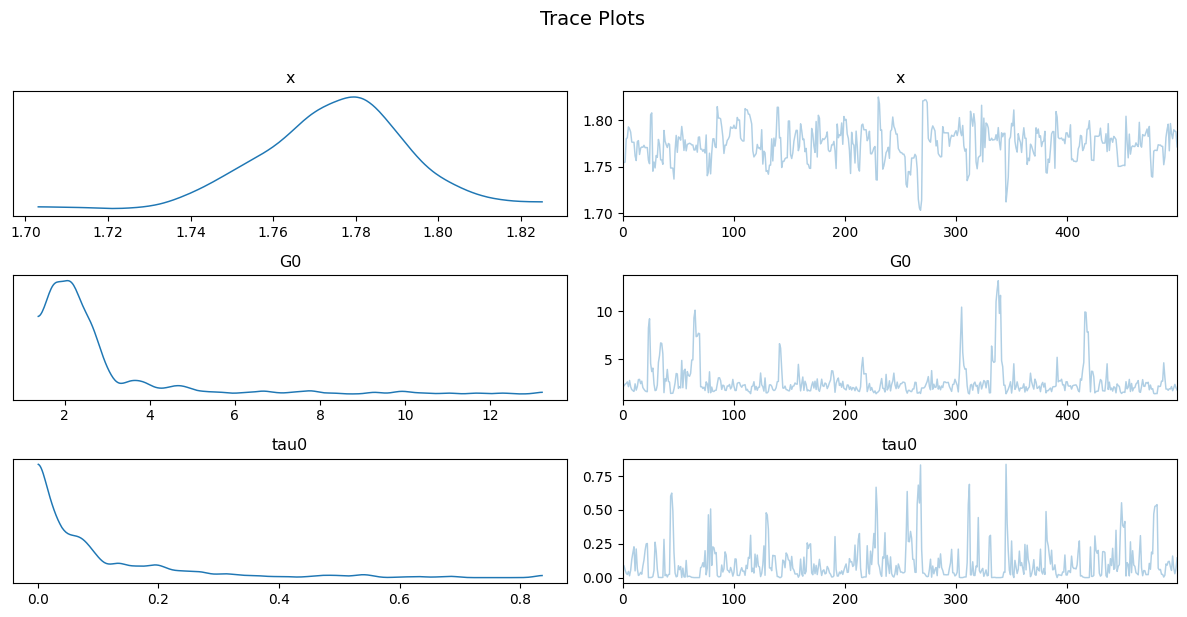

In [11]:
idata = result.to_inference_data()
axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 6))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

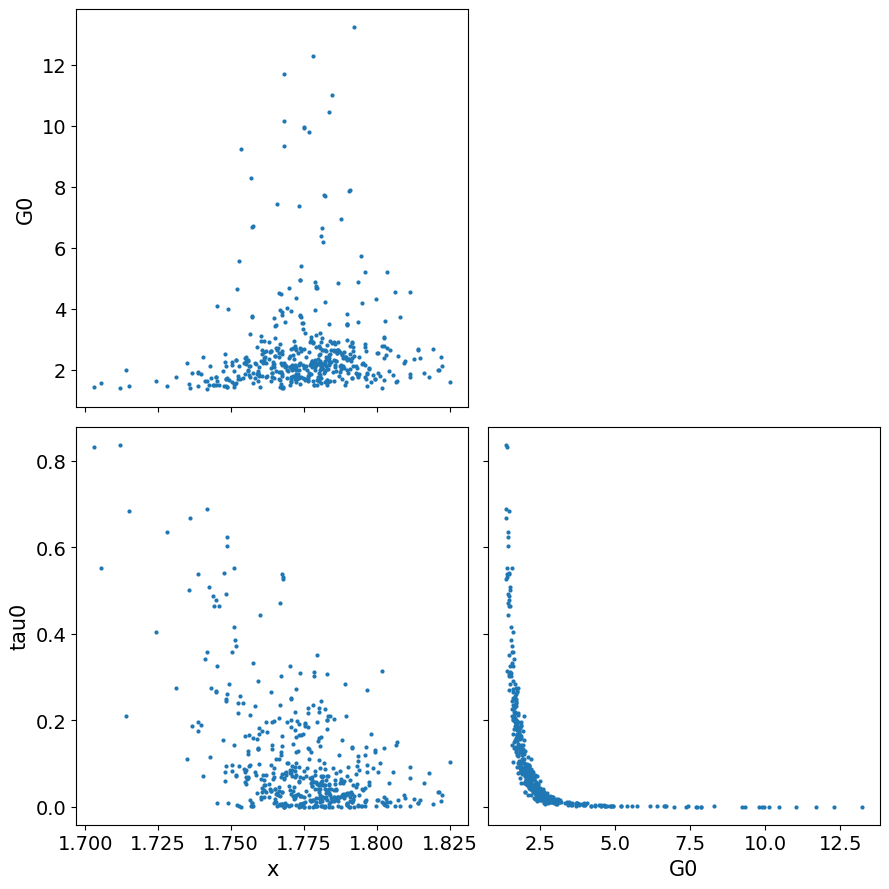

In [12]:
axes = az.plot_pair(idata, var_names=param_names, kind="scatter", divergences=True, figsize=(9, 9))
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

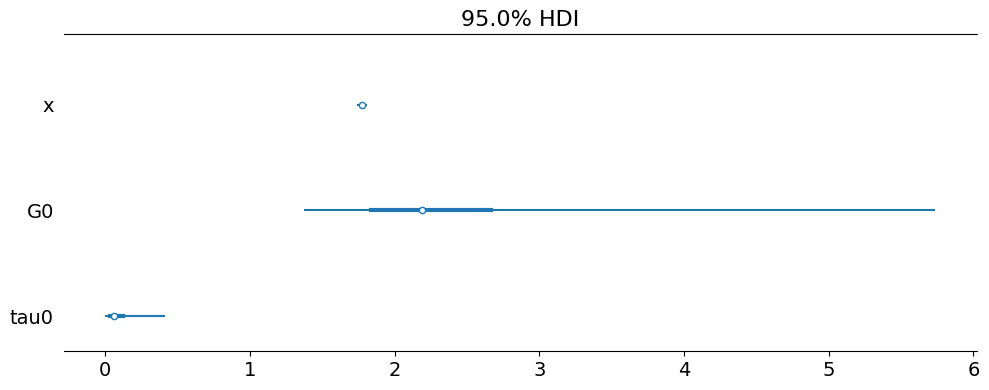

In [13]:
axes = az.plot_forest(idata, var_names=param_names, combined=True, hdi_prob=0.95, figsize=(10, 4))
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

### 5.4 Posterior Predictive

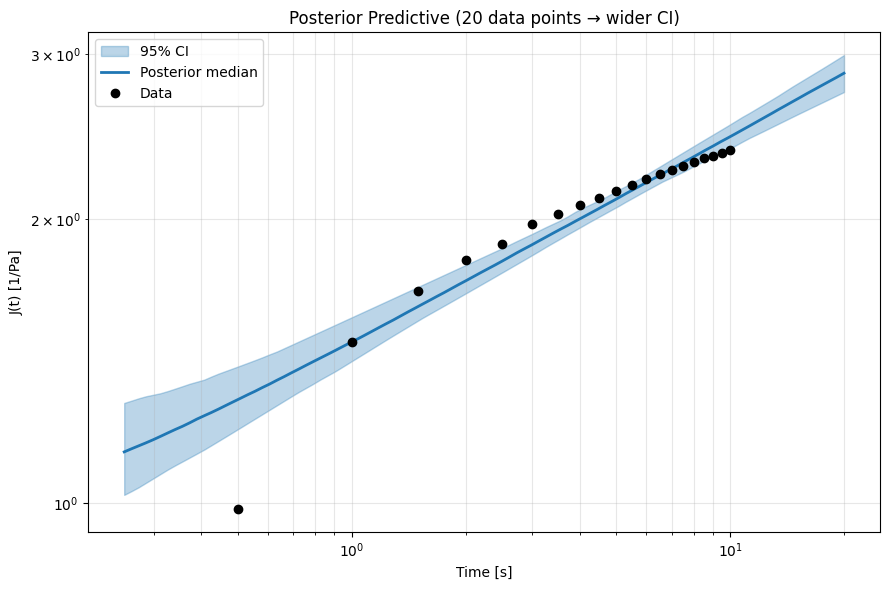

In [14]:
posterior = result.posterior_samples
n_draws = min(200, len(list(posterior.values())[0]))
t_pred = np.logspace(np.log10(max(t.min(), 0.1)) - 0.3, np.log10(t.max()) + 0.3, 100)

pred_samples = []
for i in range(n_draws):
    # Set parameters from posterior
    for name in ["x", "G0", "tau0"]:
        model.parameters.set_value(name, float(posterior[name][i]))
    pred_i = model.predict(t_pred)
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(t_pred, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI")
ax.loglog(t_pred, pred_median, "-", lw=2, color="C0", label="Posterior median")
ax.loglog(t, J_t, "ko", markersize=6, label="Data")
ax.set_xlabel("Time [s]")
ax.set_ylabel("J(t) [1/Pa]")
ax.set_title("Posterior Predictive (20 data points → wider CI)")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 5.5 Limited-Data Bayesian Discussion

With only 20 data points, the posteriors are wider — this is expected and informative:

1. **Wider CI reflects genuine uncertainty** from sparse data
2. **The posterior still constrains x meaningfully** — the power-law slope is robust
3. **G₀ and τ₀ may show stronger correlations** (identifiability challenge)
4. **Production runs with 4 chains are especially important here** for R-hat validation

This is a feature, not a bug: Bayesian inference correctly propagates data scarcity into posterior uncertainty.

## 6. Save Results

In [15]:
output_dir = os.path.join("..", "outputs", "sgr", "creep")
os.makedirs(output_dir, exist_ok=True)

nlsq_params = {name: float(model.parameters.get_value(name)) for name in ["x", "G0", "tau0"]}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/sgr/creep/


## Key Takeaways

1. **SGR creep** $J(t) \sim (1+t/\tau_0)^{2-x}$ — power-law growth encodes phase regime
2. **Biological soft matter** (mucus) exhibits soft glassy creep behavior
3. **Limited data (20 pts)** gives wider posteriors — this is physically meaningful, not a bug
4. **The creep exponent $(2-x)$** is complementary to the relaxation exponent $(x-2)$: they sum to zero
5. **SGRGeneric does not support creep** — `SGRConventional` only for this protocol

**Next:** NB 05 (startup) or NB 06 (LAOS) for nonlinear protocols